In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras # implementing neural networks
from keras.models import Sequential # appropriate where each layer has exactly one input and one output
from keras.layers import Dense # a dense layer is a layer where the neurons of the layer are connected to every neuron of its preceding layer
from keras.layers import LSTM # a variation of recurrent neural network, has a feedback loop in its architecture
from keras.layers import Activation # applies an activation function to an output
from keras.layers import Embedding # turn positive integers into dense vectors of fixed size
from keras.layers import Bidirectional # connecting two hidden layers of the opposite directions to same output
from keras.layers import Dropout

import nltk # ntlk = Natural Language Toolkit (Python Package)
nltk.download('stopwords')
from nltk.corpus import stopwords # stopwords - words that you do not want to use to describe the topic of your content 

import re # regular expression

from keras.preprocessing.text import one_hot # one-hot encodes a text into a list of word indexes of size n
from keras.utils import pad_sequences

import seaborn as sb
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#max_features = 20000  # Only consider the top 20k words
maxlen = 300

vocab_size = 20000

In [ ]:
train_data = pd.read_json('/content/train.json') # read a csv file into DataFrame
test_data = pd.read_json('/content/test.json')
train_data.head() # returns the first n rows, default is 5

,reviews,sentiments
0,I bought this belt for my daughter in-law for ...,1
1,The size was perfect and so was the color. It...,1
2,"Fits and feels good, esp. for doing a swim rac...",1
3,These socks are absolutely the best. I take pi...,1
4,Thank you so much for the speedy delivery they...,1


In [ ]:
train_data.info() # get summary of the dataframe (number of entries, datatype of each column)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7401 entries, 0 to 7400
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviews     7401 non-null   object
 1   sentiments  7401 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 115.8+ KB


In [ ]:
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english')) # get english stopword
    if text:
        text = ' '.join(text.split('.')) # split text by '.' and join back with a space
        text = re.sub('\/',' ',text) # replace / with space
        text = re.sub(r'\\',' ',text) # replace backslash with space
        text = re.sub(r'((http)\S+)','',text) # remove http link
				# firstly, remove leading and trailing whitespaces
				# turn all characters into lowercase
				# remove all not alphabet character
				# replace newline with a space
				# remove leading and trailing whitespaces again
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip() 
				# replace all alphnumeric and underscore into whitespaces
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
				# save each word that is not stopword into text array
        text = [word for word in text.split() if word not in forbidden_words]
        return text
    return []

In [ ]:
# clean data for both train & test data
#label flag column with train/test
train_data['flag'] = 'TRAIN'
test_data['flag'] = 'TEST'
# concatenate pandas objects along a particular axis
# axis = 0 -> concatenate top down
# concatenate train and test data into one dataframe
total_docs = pd.concat([train_data,test_data],axis = 0,ignore_index = True)
# apply data cleaning function for Phrase column and insert it back
total_docs['reviews'] = total_docs['reviews'].apply(lambda x: ' '.join(text_cleaning(x)))




In [ ]:
# count the unique words in the reviews
train_reviews = total_docs[total_docs['flag'] == 'TRAIN']['reviews']
reviews_word = [review.split() for review in train_reviews]
unique_word = set()
for review in reviews_word:
  for word in review:
    unique_word.add(word)

len(unique_word)

13533

In [ ]:
# each value in reviews are joined into a list
reviews = total_docs['reviews'].tolist()
# print(reviews)
# encode each word into a value
encoded_reviews = [one_hot(d, vocab_size) for d in reviews]
total_docs['reviews'] = encoded_reviews
train_data_encode = total_docs[total_docs['flag'] == 'TRAIN']
test_data_encode = total_docs[total_docs['flag'] == 'TEST']
print(train_data_encode)
x_train = train_data_encode['reviews'][:5922]
y_train = train_data_encode['sentiments'][:5922]
x_val = train_data_encode['reviews'][5922:]
y_val = train_data_encode['sentiments'][5922:]

x_test = test_data_encode['reviews']

                                                reviews  sentiments   flag
0                 [301, 15884, 11483, 5509, 11409, 807]         1.0  TRAIN
1       [12645, 19289, 17372, 6941, 1030, 14813, 19728]         1.0  TRAIN
2     [8596, 11129, 14476, 4480, 615, 11019, 2855, 1...         1.0  TRAIN
3     [18230, 6596, 19085, 18327, 16930, 1102, 13911...         1.0  TRAIN
4     [16002, 10287, 14702, 9184, 17303, 14374, 6165...         1.0  TRAIN
...                                                 ...         ...    ...
7396  [301, 3936, 5653, 17069, 17428, 15431, 15462, ...         0.0  TRAIN
7397  [18926, 17100, 10593, 1242, 14476, 1302, 15475...         1.0  TRAIN
7398  [5597, 17947, 2059, 16128, 15253, 9963, 9635, ...         1.0  TRAIN
7399  [19480, 4531, 13826, 14887, 27, 3125, 18926, 5...         0.0  TRAIN
7400  [15227, 6396, 1810, 19056, 19089, 8347, 1716, ...         1.0  TRAIN

[7401 rows x 3 columns]


In [ ]:
# find out the unique values of an array and return the sorted unique values
y_train.unique()

array([1., 0.])

In [ ]:
# ensure that all sequences in a list have the same length
# padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence
# specify the maximum length of each sequence using maxlen argument. 
# This will truncate all sequences longer than maxlen
# By default truncating is set to pre, which truncates the beginning part of the sequence. 
# If you rather want to truncate the end part of the sequence you can set it to post.
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)


In [ ]:
#create a sequential model
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=32, input_length=300))
# Add 2 bidirectional LSTMs
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(4)))
model.add(Dropout(0.5))
# Add a classifier
model.add(Dense(1, activation="sigmoid"))
# model = keras.Model(inputs, outputs)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 300, 64)          16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 16)          4672      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 300, 16)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 8)                6

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=12, verbose=1)

Epoch 1/12
186/186 [==============================] - 69s 329ms/step - loss: 0.5835 - accuracy: 0.8205 - val_loss: 0.4401 - val_accuracy: 0.8519
Epoch 2/12
186/186 [==============================] - 58s 312ms/step - loss: 0.4663 - accuracy: 0.8499 - val_loss: 0.4205 - val_accuracy: 0.8519
Epoch 3/12
186/186 [==============================] - 57s 308ms/step - loss: 0.4546 - accuracy: 0.8538 - val_loss: 0.4313 - val_accuracy: 0.8519
Epoch 4/12
186/186 [==============================] - 57s 306ms/step - loss: 0.4444 - accuracy: 0.8543 - val_loss: 0.4136 - val_accuracy: 0.8519
Epoch 5/12
186/186 [==============================] - 58s 312ms/step - loss: 0.4282 - accuracy: 0.8543 - val_loss: 0.3945 - val_accuracy: 0.8519
Epoch 6/12
186/186 [==============================] - 58s 311ms/step - loss: 0.3901 - accuracy: 0.8560 - val_loss: 0.3483 - val_accuracy: 0.8519
Epoch 7/12
186/186 [==============================] - 57s 306ms/step - loss: 0.3400 - accuracy: 0.8636 - val_loss: 0.3202 - val_ac

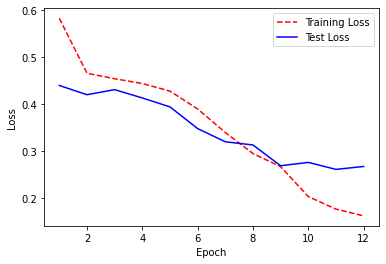

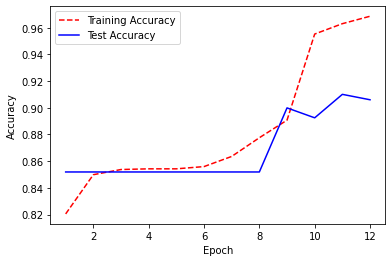

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
test_accuracy= history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [ ]:
# make prediction for test data based on the model constructed
y_val_predict = model.predict(x_val)

# since the output are floating numbers between 0 and 1
# set a threshold to convert it to 0 or 1
# if <= 0.5, sentiment = 0
# if > 0.5, sentiment = 1
threshold = 0.5
y_val_predict = np.where(y_val_predict > threshold, 1, 0)

y_val_predict

47/47 [==============================] - 4s 57ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

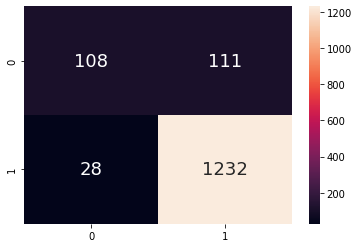

In [ ]:
sb.heatmap(confusion_matrix(y_val, y_val_predict), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
# make prediction for test data based on the model constructed
y_test = model.predict(x_test)

# since the output are floating numbers between 0 and 1
# set a threshold to convert it to 0 or 1
# if <= 0.5, sentiment = 0
# if > 0.5, sentiment = 1
threshold = 0.5
y_test = np.where(y_test > threshold, 1, 0)

y_test

58/58 [==============================] - 3s 57ms/step


array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
# insert the predicted value into the sentiments column in test data
test_data['sentiments'] = y_test
test_data

,reviews,flag,sentiments
0,I bought 2 sleepers. sleeper had holes in the...,TEST,0
1,I dare say these are just about the sexiest th...,TEST,1
2,"everything about the transaction (price, deliv...",TEST,1
3,"Not bad for just a shirt. Very durable, and m...",TEST,1
4,These are truly wrinkle free and longer than t...,TEST,1
...,...,...,...
1846,These are stylish and nice and perfect to wear...,TEST,1
1847,We bought these long-sleeved colored shirts fo...,TEST,1
1848,These are really cute and very sexy. They wil...,TEST,1
1849,These shoers were for my daughter. She loves ...,TEST,1


In [ ]:
test_data.to_csv('/content/submission.csv')